In [1]:
%%capture
!pip install opendatasets
!pip install spacy_lookups_data

## Download the data set

In [2]:
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sanguire
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews


100%|██████████| 25.7M/25.7M [00:00<00:00, 165MB/s]

In [3]:
import pandas as pd
import re
import spacy
from spacy.tokenizer import Tokenizer
from spacy.language import Language
from spacy.lang.en import English
from spacy.util import compile_prefix_regex, compile_suffix_regex, compile_infix_regex
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Load dataset

In [4]:
df = pd.read_csv('imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Text processing pipeline
We use spacy and nltk to process textual data

In [7]:
#@Language.factory(name = 'custom_lemmatizer')
# def create_lemmatizer_2(nlp, name):
#   def lemme(doc):
#     for i in range(len(doc)):
#       doc[i].lemma_ = lemmatizer.lemmatize(doc[i].text)
#     return doc
#   return lemme

# or
@Language.factory(name = 'custom_lemmatizer')
def create_lemmatizer(nlp, name):
  return CustomLemmatizer(lem = WordNetLemmatizer())

class CustomLemmatizer:
  def __init__(self, lem):
    self.lemmatizer = lem

  def __call__(self, doc):
    for i in range(len(doc)):
      doc[i].lemma_ = self.lemmatizer.lemmatize(doc[i].text)
    return doc

# print doc
@Language.component(name = 'print_info')
def custom_print_info(doc):
  print([(i.text, i.lemma_) for i in doc])
  return doc

In [40]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

### Text cleaning
A simple text cleaning process: remove whitespaces at the begining and the end and lowercase the test

In [26]:
class TextPreprocessor(TransformerMixin):
  def transform(self, X):
    """
    Strip whitespaces and lowercase the text
    """
    return [doc.strip().lower() for doc in X]

  def fit(self, X, y = None, **fit_params):
    return self

### Define spacy pipeline</br>
The text processing pipeline is: Tokenize -> Lemmatize

In [35]:
# Spacy pipeline text processing
nlp = spacy.blank('en')

prefixes = nlp.Defaults.prefixes
suffixes = nlp.Defaults.suffixes
infixes = nlp.Defaults.infixes
#
prefix_re = compile_prefix_regex(suffixes)
suffix_re = compile_suffix_regex(suffixes)
infix_re = compile_infix_regex(infixes)
# tokenizer
tokenizer = Tokenizer(English().vocab,\
                      prefix_search = prefix_re.search,\
                      suffix_search = suffix_re.search,\
                      infix_finditer = infix_re.finditer)
nlp.tokenizer = tokenizer
# lemmatizer
nlp.add_pipe('custom_lemmatizer', name='lemme_it', last = True)

def spacy_tokenizer(doc):
  return [token.lemma_ for token in nlp(doc) if not (token.is_stop or token.is_punct)]

## Define data pipeline
The pipeline is: Data cleaning -> Vectorizer -> Classifier

In [46]:
sk_pipeline = Pipeline([
  ('preprocessor', TextPreprocessor()),
  ('vectorizer', TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))),
  ('classifier', LogisticRegression())
])

## Training
Split data

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size = 0.2, random_state = 42)

Fit training data

In [48]:
sk_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 <__main__.TextPreprocessor object at 0x797a6031f8b0>),
                ('vectorizer',
                 TfidfVectorizer(tokenizer=<function spacy_tokenizer at 0x797a64fee710>)),
                ('classifier', LogisticRegression())])

Evaluate on test dataset

              precision    recall  f1-score   support

    negative       0.91      0.88      0.89      4961
    positive       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



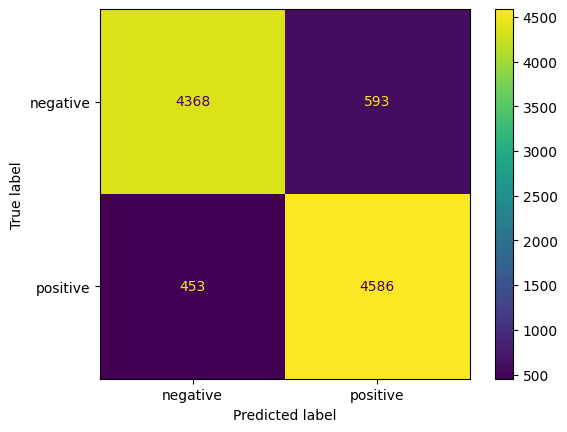

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
y_pred = sk_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)